In [81]:
import csv
import json
csvfile = open('./data/电商红酒.csv', 'r')
reader = csv.reader(csvfile)#读取到的数据是将每行数据当做列表返回的
rows = []#用来存储解析后的没条数据
for row in reader:
    row_str = ",".join(row)#row为list类型需转为str，该数据变为字典型字符串
    row_dict = json.loads(row_str)#
    #将每行数据中嵌套字典拆开存储到列表中
    newdict = {}
    for k in row_dict:
        if type(row_dict[k]) == str:#将键值对赋给新字典
            newdict[k] = row_dict[k]
        elif type(row_dict[k]) == dict:#若存在嵌套字典，将该字典中的key和value作为属性和属性值
            newdict.update(row_dict[k])
    rows.append(newdict)

In [82]:
import pandas as pd
df = pd.DataFrame(rows)#将字典型数组转为DataFrame形式
#将DataFrame 写入到 csv 文件
df.to_csv("wine_df_shop.csv",encoding="utf-8_sig", index = False)

In [83]:
print(df.shape)
print(df.columns.values)

(33734, 266)
['CT数' 'ISBN' 'id' 'keyword' 'name' 'price' 'shop_id' 'shop_name' 'sku_id'
 'url' '丛书名' '中图法分类号' '主体材质' '主色调' '主袋' '主要材质成分' '主题词' '书写' '产区' '产品产地'
 '产品净重(kg)' '产品净重（kg）' '产品包装' '产品包装尺寸' '产品包装尺寸（cm）' '产品包装重量（kg）' '产品品牌'
 '产品型号' '产品尺寸(mm)' '产品尺寸（cm）' '产品尺寸（mm）' '产品尺寸（长*宽*高）' '产品尺寸（长*宽）CM：'
 '产品尺寸（长x宽x高mm）' '产品展开尺寸（cm)' '产品展开尺寸（cm）' '产品展示尺寸（cm)' '产品展示尺寸（cm）'
 '产品执行标准' '产品承重量（kg）' '产品承重（kg）' '产品标准号' '产品类别' '产品重量（kg）' '产地' '人群' '介质'
 '作者' '使用尺寸（cm）' '保温时间' '保质期' '保质期（年）' '储存方法' '光源个数' '光源类型' '冷冻容积（L）'
 '冷冻能力(kg/24h)' '冷藏容积（L）' '净含量' '净含量（kg）' '净含量（mL/g）' '净含量（mL）' '净尺寸(mm)'
 '净重(KG)' '净重量（kg）' '出版时间' '出版社' '分类' '制冷方式' '功效' '功率(W)' '功能' '功能位'
 '功能特性' '包装' '包装尺寸（cm）' '包装礼盒' '包装规格' '单片净含量（mL）' '印刷时间' '印次' '厚度' '原产国'
 '原产地' '原料' '原材料产地' '原麦汁浓度' '口味' '口感' '口述' '品牌' '品相' '品类' '商品包装'
 '商品承重量（kg）' '商品承重（kg）' '固定方式' '国产/进口' '国别' '图案' '图片形式' '地区' '场合' '场景'
 '型号' '填充物' '壁饰题材' '外壳材质' '外文名' '头数' '套装数量' '妆效' '字幕语言' '字数' '存储方法' '安装方式'
 '审图号' '容积（L）' '容量' '容量(L)' '容量（ml）' '导演' '尺寸' '尺寸（cm）' '尺

In [84]:
# 处理红酒名称（统一规范中文/英文的格式）
#去keyword中“红酒”字符
df['keyword']=df['keyword'].str.split('红酒').str[0]

#整理红酒品牌
brand = pd.read_csv("./data/红酒品牌.csv",header=None,encoding="utf-8")
brands =[]
for k1,k2 in zip(list(brand[0]),list(brand[1])):
    if pd.isnull(k2):
        brands.append(k1)
    else:
        brands.append(k1+"/"+k2)
        
# 品牌替换
def modify_keywords(w, lists):
    for b in lists:
        if w.strip() in b:
            return b
    return w.strip()


df['keyword'] = df['keyword'].apply(modify_keywords, lists =brands)
df['keyword']=df['keyword'].str.lower()#转化为小写

print(df["keyword"].head(10))

0                 泸州老窖
1                   美绚
2           通化/tonghua
3        长城/greatwall 
4        长城/greatwall 
5    干露/concha y toro 
6            拉菲/lafite
7            山图/shantu
8            山图/shantu
9            山图/shantu
Name: keyword, dtype: object


************************************************
2.1.1 [去重]()
************************************************

In [85]:
#若爬取数据有相同的url，则认为是相同数据，只保留一条

#数据是否有相同行，若有返回true，否则False
if df.duplicated(subset=["url"], keep=False).any(): 
    print("存在重复数据")
    df = df.drop_duplicates(subset=["url"], keep="first")
else:
    print("不存在重复数据")
print(df.shape)

不存在重复数据
(33734, 266)


************************************************
2.1.2 [去除非红酒数据]()
************************************************

In [86]:
df = df.dropna(subset=["甜度"])
print(df.shape)

(18734, 266)


************************************************
2.1.3 [处理750ml,价格]()

将删除“产品重量”属性，因为包装不同，礼盒或者整箱产品包装中带有赠品，酒杯酒具等物品，质量变化数据不可靠，难以清洗。
************************************************

In [87]:
# 提取瓶数和重新计算价格
#红酒商品描述中有含有的数字主要有三种年份、容量和瓶数，容量固定为750，主要识别瓶数

# 挑出含750字样的数据
df = df[df["name"].str.contains("750")]
print(df.shape)

#处理价格
import jieba.posseg as pseg

def get_numbers(words, num_type = "int"):
    """返回string中的数字
    Args:
        words: 字符串
        num_type: 获取字符串中float型数字还是int型数字
    """
    nums = []
    for w,p in pseg.cut(words): #jieba词性标注不能将“750ml*6"中的6识别为数字，换一种方式
        if num_type == "int":
            try: nums.append(int(w))
            except:continue
        if num_type == "float":
            try: nums.append(float(w))
            except:continue
    return nums

wine_bottles = {}          #存放红酒瓶数字典
with open("./dict/wine_bottles.txt","r",encoding = "utf-8") as f:
    for line in f.readlines():
        k,v = line.strip().split(" ")
        wine_bottles[k]=v

df_index = df.index.tolist()  #获取df索引列表
df["price"] = df["price"].astype("float") #更改数据类型

for i, name in zip(df_index, df["name"]):
    bottles = [int(wine_bottles[k])for k in wine_bottles if name.find(k) != -1]    #
    if len(bottles) == 1:
        df['price'].loc[i] = float('%.2f' % (df['price'].loc[i]/bottles[0]))
        continue
    elif len(bottles)>1:
        df = df.drop(index = i,axis = 0)
        continue
        
    numbers = get_numbers(name,"int")        #bottles==0，用jieba分词提取红酒标题中的数字
    if 750 not in numbers:        #选取是含有750的样本，但结巴分词可能将750切成其他组合词，识别不出750这个数字，删除
        df = df.drop(index = i,axis = 0)
        continue
    numbers = [n for n in get_numbers(name,"int") if n in [750,1,2,3,4,5,6,8,12]]        #提取标题中特定数字
    if len(numbers) == numbers.count(750):         #只有750数字,认为是单瓶不处理
        continue
    if numbers.count(750) > 1:        #存在多个数字且750个数有多个，删除
            df = df.drop(index = i,axis = 0)
            continue
    if numbers.index(750) == 0:        #存在多个数字，750只有一个，且750后面有数字,更改
        df['price'].loc[i] = float('%.2f' % (df['price'].loc[i]/numbers[1]))
    elif numbers.index(750) == -1:        #存在多个数字，750只有一个，且750前面有数字，更改
        df['price'].loc[i] = float('%.2f' % (df['price'].loc[i]/numbers[-2]))
    else:
         df = df.drop(index = i,axis = 0)    #存在多个数字，750只有一个，且750前面后面都有数字，删除
            
df.drop(["name","包装","容量","产品重量（kg）"], axis=1, inplace=True)

(12990, 266)


/usr/local/python3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


************************************************
2.1.4 [删选列]()
************************************************

In [88]:
print("每列缺失值个数:")
print(df.isnull().sum())#统计每列的缺失值个数

每列缺失值个数:
CT数           11648
ISBN          11648
id                0
keyword           0
price             0
shop_id           0
shop_name         0
sku_id            0
url               0
丛书名           11648
中图法分类号        11648
主体材质          11648
主色调           11648
主袋            11648
主要材质成分        11648
主题词           11648
书写            11648
产区                0
产品产地          11648
产品净重(kg)      11648
产品净重（kg）      11648
产品包装          11648
产品包装尺寸        11648
产品包装尺寸（cm）    11648
产品包装重量（kg）    11648
产品品牌          11648
产品型号          11648
产品尺寸(mm)      11648
产品尺寸（cm）      11648
产品尺寸（mm）      11648
              ...  
适用人群          11648
适用场景          11648
适用型号          11648
适用季节          11648
适用对象          11648
适用尺寸          11648
适用炉灶          11648
适用空间          11648
造型            11648
配料            11648
配音语言          11648
酒精度               0
重量（g）         11648
重量（kg）        11648
钥匙孔           11648
链子材质          11648
链子样式          11648
镜面材质          11648
长度(m)      

In [89]:
#删除列数据，thresh作用：保留至少有2329（11648*20%）个非 NA 数的列
df = df.dropna(axis=1,thresh=2329)
# 再删除["id","shop_id","shop_name","sku_id","url"]
df.drop(["id","shop_id","shop_name","sku_id","url"],axis=1,inplace=True)

******************************************************
2.2 [处理空值]()

主要是处理      类别    和    特性    缺失值用   众数    代替


******************************************************

In [90]:
df.columns.values

array(['keyword', 'price', '产区', '保质期', '原产地', '口感', '国产/进口', '存储方法',
       '年份', '特性', '甜度', '类别', '葡萄品种', '酒精度', '颜色'], dtype=object)

In [91]:
df.isnull().sum()

keyword      0
price        0
产区           0
保质期          0
原产地          0
口感           0
国产/进口        0
存储方法         0
年份           0
特性         117
甜度           0
类别          41
葡萄品种         0
酒精度          0
颜色           0
dtype: int64

In [92]:
df.groupby("特性").size().sort_values(ascending=False)

特性
普通餐酒               6123
精品葡萄酒              1563
列级庄                1455
法定产区酒（AOC/AOP等）     958
名庄葡萄酒               586
中级庄                 578
酒杯/酒具               167
有机葡萄酒                76
AOC/AOP              25
dtype: int64

In [93]:
# 众数替代缺失值

#上述统计结果可以看出“特性”和“类别”出现缺失值
def process_nan(col,gp_col,df):
    #计算该列分组众数,可能出现某个品牌的众数为nan，以“no match”代替
    df_mode = df.groupby(gp_col)[col].agg(lambda x: next(iter(x.value_counts().index), 'no match'))
    df[col] = df[col].fillna(df[gp_col].map(df_mode))
    df = df[~df[col].isin(["no match"])] #删除“no match”
    return df
    
df = process_nan("特性", "keyword", df)
df = process_nan("类别", "keyword", df)

# 保存数据
df.to_csv("pre-processed.csv",encoding="utf-8_sig",index = False)

******************************************************
2.3 [pandaBI观察各维度特征再处理]()

- 存储方法：大部分数据是形容不能避光阴凉的不同说法，选择删除

- 原产地，甜度，颜色：含有部分取值为“其他”的数据，采用同一红酒品牌的众数替代策略予以调整

- 类别，葡萄品种：采用onehot编码的理论思想对数据进行转换

- 年份：数据中包含有很多“以实物为准”，“见瓶身”这种取值，但我们想知道的是酒的年龄，处理方式是利用文本处理的分词技术提取其中的年份，再与当前年份相减；部分数据的年份给的是一个范围值，此时取平均值；没有年份则用9999代替。

- 酒精度：同“年份”属性一样，有数据不规范，“实物为准”的取值问题，同样采用文本处理的分词技术提取酒精度的数值。
- 保质期：书写格式非常不统一，有些是按天为单位，有些是按年为单位，且有数字有中文的不同表达，该属性予以删除。

******************************************************

In [94]:
df.drop(["保质期","存储方法"], axis=1, inplace=True)

In [95]:
# 处理 原产地，甜度，颜色
def process_others(col, gp_col, df_other, df_mode,df):
    other_series = df_other[col]
    names = list(df.loc[other_series,gp_col])
    t = df_mode.loc[names,col]
    t.index = df.loc[other_series,col].index #col中含有“其它”的索引
    df.loc[other_series,col] = t
    return df

cols = ["原产地","甜度","颜色"] #需要处理的列
gp_col = 'keyword'  #分组列
df_mode = df.groupby('keyword').agg(lambda x: x.value_counts().index[0]) #根据keyword（品牌）分组计算众数
# print(df_mode[cols]) #每个红酒品牌在属性列上的众数

for col in cols:
    df_other = pd.DataFrame(df[col]=="其它") #col中存在“其它”的行
    df = process_others(col, gp_col, df_other, df_mode, df)
    #因为某品牌红酒在某列上的众数可能是“其它”，经过众数替换后再删除仍存在的“其它”的行
    df = df[~df[col].isin(["其它"])] #通过~取反，选取col中不包含“其它”的行

In [96]:
df.shape

(10951, 13)

In [97]:
# 处理 类别
# list(df.groupby("类别").count().index)
lbs = ["冰酒/贵腐/甜酒","白葡萄酒","果味葡萄酒","桃红葡萄酒","起泡酒/香槟","红葡萄酒"]

df["冰酒/贵腐/甜酒"] = df['类别'].apply(lambda x : 1 if str(x).find("冰酒") != -1 or str(x).find("贵腐")!= -1 or str(x).find("甜酒")!= -1 else 0)
df["白葡萄酒"] = df['类别'].apply(lambda x : 1 if str(x).find("白葡萄酒") != -1 else 0)
df["果味葡萄酒"] = df['类别'].apply(lambda x : 1 if str(x).find("果味葡萄酒") != -1 else 0)
df["桃红葡萄酒"] = df['类别'].apply(lambda x : 1 if str(x).find("桃红葡萄酒") != -1 else 0)
df["红葡萄酒"] = df['类别'].apply(lambda x : 1 if str(x).find("红葡萄酒") != -1 else 0)
df["起泡酒/香槟"] = df['类别'].apply(lambda x : 1 if str(x).find("起泡酒") != -1 or str(x).find("香槟") != -1 else 0)

# df[['类别']+lbs].head
df.drop("类别", axis=1, inplace=True)

In [98]:
# 处理葡萄品种
## 获取葡萄的所有品种类别
tmp = list(df.groupby("葡萄品种").count().index)
graps = []
for i in tmp:
    graps += i.split("|")
graps = list(set(graps))
print(graps)
del tmp

## 处理每个葡萄品种
for j in graps:
    df[j] = df['葡萄品种'].apply(lambda x : 1 if str(x).find(j) != -1 else 0)
    
# print(df[graps+['葡萄品种']].head)
df.drop("葡萄品种", axis=1, inplace=True)

['马尔贝克（Malbec）', '其它', '梅洛（Merlot）', '仙粉黛（Zinfandel）', '赤霞珠（Cabernet Sauvignon）', '西拉/设拉子（Syrah/Shiraz）', '雷司令（Riesling）', '桑娇维塞（Sangiovese）', '黑皮诺（Pinot Noir）', '长相思（Sauvignon Blanc）', '内比奥罗（Nebbiolo）', '佳美（Gamay）', '品丽珠（Cabernet Franc）', '匹诺塔吉（Pinotage）', '霞多丽（Chardonnay）', '蛇龙珠（Cabernet Gernischt）', '佳美娜（Carmenere）']


In [99]:
import numpy as np
#处理年份,
#可能出现的数字有：年份(2005,2012等)，年份区间（2016-2018等），年月日(2015.08.06,2012.05等),年数(0,1,3等),年数区间（0-3等，1-3等）
       
def deal_year(x):
    numbers = []
    for w,p in pseg.cut(x):
        if p=='m':
            try:numbers.append(int(w))
            except:continue
    if len(numbers) == 0:
        return 99999   #年份中无数字，以99999代替
    years=[]
    other_nums=[]
    for n in numbers:
        if n >1800 and n < 2020:
            years.append(n)
        elif n<50:
            other_nums.append(n)
        else:
            continue
    if years:
        return 2019 - int(np.mean(years))
    elif other_nums:
        return int(np.mean(other_nums))
    else:
        return 99999 #无合理数字，以99999代替
      
df["year"] = df["年份"].map(deal_year)
df.drop("年份", axis=1, inplace=True)

In [100]:
# 处理酒精度
def deal_alcohol(x):
    numbers = []
    for w,p in pseg.cut(x):
        if p=='m':
            try:numbers.append(float(w))
            except:continue
    if len(numbers) > 1:
        return np.mean(numbers)
    elif len(numbers) == 1:
        return numbers[0]
    else:
        return 99999  # 酒精中无数字，以99999代替
        
df["alcohol"] = df["酒精度"].map(deal_alcohol)
df.drop("酒精度", axis=1, inplace=True)

In [101]:
df.to_csv("prepare_for_weibo.csv",encoding="utf-8_sig",index = False)

In [103]:
print(df["price"].min())
print(df["price"].max())

3.32
79560.0


/usr/local/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


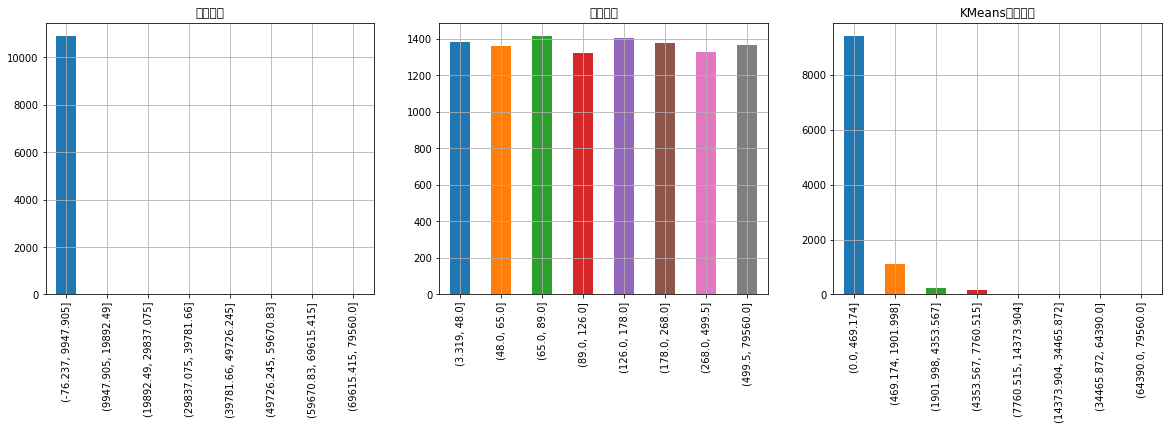

In [115]:
# 三种方式对价格的划分
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

k = 8
kmodel = KMeans(n_clusters = k,n_jobs=5)

fig,ax= plt.subplots(1,3,figsize=(20,5))
cat = pd.cut(df['price'],k)
cat2 = pd.qcut(df['price'],k)
kmodel.fit(df['price'].values.reshape(len(df),1))
c = pd.DataFrame(kmodel.cluster_centers_).sort_values(0)
w = c.rolling(2).mean().iloc[1:]
w = [0] + list(w[0]) + [df['price'].max()] 
cat3 = pd.cut(df['price'], w)

cat.value_counts(sort = False).plot.bar(grid= True,ax=ax[0],title = '等宽分箱')
cat2.value_counts(sort = False).plot.bar(grid= True,ax=ax[1],title = '等频分箱')
cat3.value_counts(sort = False).plot.bar(grid= True,ax=ax[2],title = 'KMeans聚类分箱')

/usr/local/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


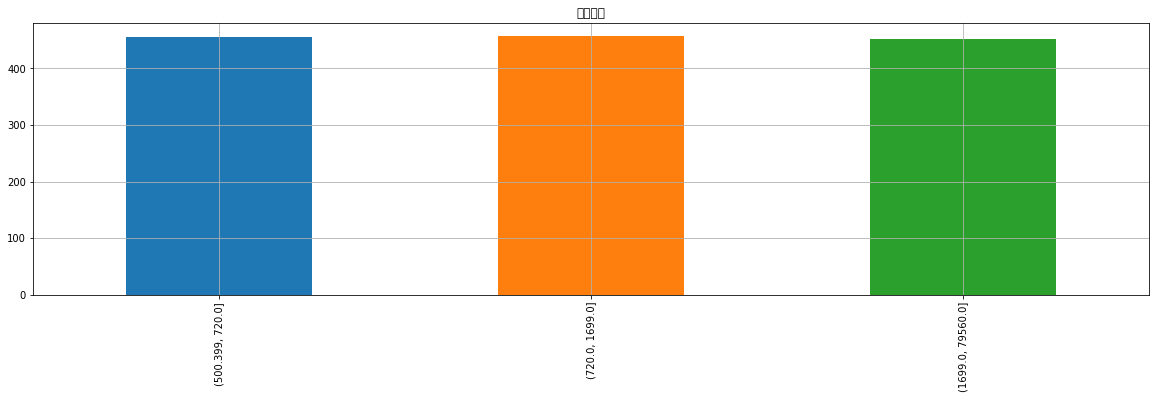

In [116]:
df3 = df[df["price"]>500]
fig,ax= plt.subplots(1,1,figsize=(20,5))
cat4 = pd.qcut(df3['price'],3)
cat4.value_counts(sort = False).plot.bar(grid= True,title = '等频分箱')

/usr/local/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


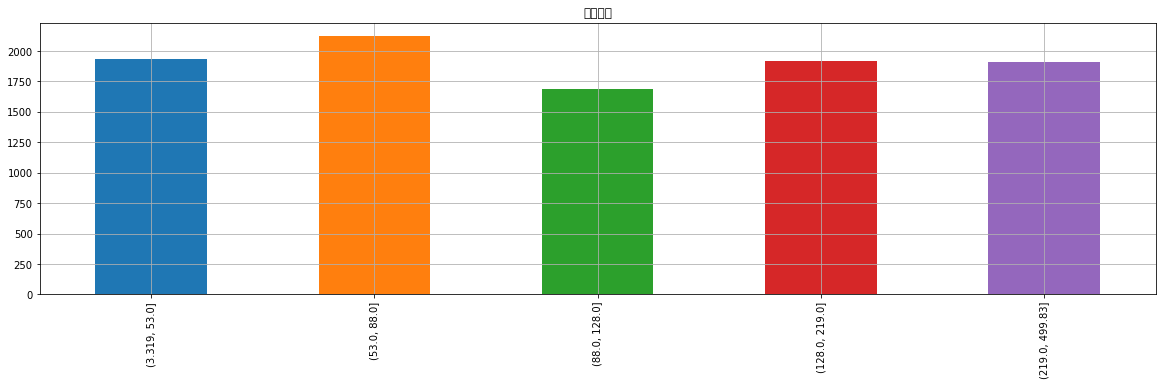

In [117]:
df4 = df[df["price"]<=500]
fig,ax= plt.subplots(1,1,figsize=(20,5))
cat4 = pd.qcut(df4['price'],5)
cat4.value_counts(sort = False).plot.bar(grid= True,title = '等频分箱')

In [ ]:
# 处理价格区间
# 价格区间划分为：[0,50],[50,100],[100,150],[150,250],[250,500],[500,1000],[1000,2000],[2000,max]
import sys 
def get_price_scope(price):        #获取价格区间
    scope = [[0,50],[50,100],[100,150],[150,250],[250,500],[500,1000],[1000,2000],[2000,sys.maxsize]]
    for j in range(len(scope)):
        if price >= scope[j][0] and price < scope[j][1]:
            result = '-'.join(str(x) for x in scope[j])
    return result
df['price'] = df['price'].map(get_price_scope)

In [ ]:
df.to_csv("wine_processed.csv",encoding="utf-8_sig",index = False)

In [ ]:
df2.groupby("keyword").agg({"price":["min","max"]})